# CS 324 Final Project: MUSIC GENERATION 

Enter your name and EID in the following block:

Aleric Hunziker(afj697)

Jamie Wong (jw55449)

Truc Tran (ttt2436)

# Step 1: Preprocessing Data

In [43]:
import torch
from torch import nn
import numpy as np
import scipy.signal
import pandas as pd

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, LSTM
import pickle
import glob 
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import music21
import tensorflow as tf
# for making midi file
import mido
from mido import MidiFile, MidiTrack, Message
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [44]:

# Read through a directory of classical piano MIDI files, extract and print the note pitches and chord structures
from music21 import converter, note, chord, instrument

# Store parsed MIDI files and extracted data
midis = []
collections = {
    'notes': [],
    'starts': [],
    'ends' : [],
    'steps': [],
    'velocities':[],
    'durations': []
}

for file in glob.glob("mozart/*.mid"):
    try:
        # Parses the MIDI file into a music21 stream.
        midi = converter.parse(file)
        midis.append(midi)
        notes_to_parse = midi.flat.notes
        prev_start = notes_to_parse[0].offset if len(notes_to_parse) > 0 else 0

        for element in notes_to_parse:
            if isinstance(element, note.Note) or isinstance(element, chord.Chord):
                if isinstance(element, note.Note):
                    elements = [element]
                else:  # It's a chord
                    elements = element.notes

                for single_note in elements:
                    pitch = str(single_note.pitch) if isinstance(single_note, note.Note) else '.'.join(str(n) for n in single_note.normalOrder)
                    duration = single_note.duration.quarterLength
                    velocity = single_note.volume.velocity if single_note.volume.velocity is not None else "N/A"
                    start = single_note.offset
                    end = single_note.offset + single_note.duration.quarterLength

                    collections['notes'].append(pitch)
                    collections['starts'].append(start)
                    collections['ends'].append(end)
                    collections['steps'].append(start - prev_start)
                    collections['velocities'].append(velocity)
                    collections['durations'].append(duration)

                    prev_start = start

    except Exception as e:
        print(f"Failed to process {file}: {str(e)}")

# Convert collections to a DataFrame
df_collections = pd.DataFrame(collections)

print("Length of collections: ", len(df_collections))
print("Sample data from collections DataFrame:")
print(df_collections.head())

# Additional prints to check data extraction
print("\nFirst 10 Notes: ", collections['notes'][:10])


/Users/tructran/.pyenv/versions/3.11.5/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/Users/tructran/.pyenv/versions/3.11.5/lib/python3.11/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/Users/tructran/.pyenv/versions/3.11.5/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/Users/tructran/.pyenv/versions/3.11.5/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument

Length of collections:  68532
Sample data from collections DataFrame:
  notes starts ends steps  velocities durations
0   B-4    0.0  2.0   0.0          50       2.0
1   B-3    0.0  2.0   0.0          40       2.0
2    F4    2.0  3.0   2.0          45       1.0
3    F3    2.0  3.0   0.0          36       1.0
4    D4    3.0  5.0   1.0          50       2.0

First 10 Notes:  ['B-4', 'B-3', 'F4', 'F3', 'D4', 'D3', 'F4', 'F3', 'B-4', 'B-3']


In [45]:

# Convert data dictionary to structured arrays for processing
features = np.column_stack([df_collections[key] for key in df_collections.keys() if key != 'notes'])
print("feature: ", features)
print("feature shape: ", features.shape)



# Normalize numerical data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Encode notes
label_encoder = LabelEncoder()
notes_encoded = label_encoder.fit_transform(df_collections['notes'])
notes_categorical = to_categorical(notes_encoded)
# print("notes_categorical: ", notes_categorical[:10])
# print("label_encoded: ", notes_encoded)

# Create input sequences for LSTM
sequence_length = 32
input_data = []
output_data = []

for i in range(len(notes_categorical) - sequence_length):
    input_data.append(np.hstack((features_scaled[i:i+sequence_length], notes_categorical[i:i+sequence_length])))
    output_data.append(notes_categorical[i + sequence_length])

input_data = np.array(input_data)
output_data = np.array(output_data)
print("input shape:", input_data.shape)
print("output shape:", output_data.shape)
# print("input: ", input_data)
# print("output: ", output_data)


feature:  [[0.0 2.0 0.0 50 2.0]
 [0.0 2.0 0.0 40 2.0]
 [2.0 3.0 2.0 45 1.0]
 ...
 [0.0 1.0 0.0 72 1.0]
 [0.0 1.0 0.0 72 1.0]
 [0.0 1.0 0.0 85 1.0]]
feature shape:  (68532, 5)
input shape: (68500, 32, 67)
output shape: (68500, 62)


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input


def create_model(input_shape, num_classes):
    model = Sequential([
        LSTM(256, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(128, return_sequences=False),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    # Set the learning rate
    # lr_schedule = ExponentialDecay(
    #     initial_learning_rate=0.01,
    #     decay_steps=10000,
    #     decay_rate=0.9)

    # optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    learning_rate = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the model with the optimizer, loss function, and metrics
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Model instantiation
model = create_model(input_data.shape[1:], len(label_encoder.classes_))


# Saving the trained LabelEncoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

/Users/tructran/.pyenv/versions/3.11.5/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
model.fit(input_data, output_data, epochs=45, batch_size=64)


Epoch 1/45
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 103s 95ms/step - accuracy: 0.0791 - loss: 3.5006
Epoch 2/45
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 103s 96ms/step - accuracy: 0.1385 - loss: 3.0983
Epoch 3/45
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 101s 94ms/step - accuracy: 0.1647 - loss: 2.9492
Epoch 4/45
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 102s 95ms/step - accuracy: 0.2041 - loss: 2.8031
Epoch 5/45
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 106s 99ms/step - accuracy: 0.2502 - loss: 2.6316
Epoch 6/45
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 108s 101ms/step - accuracy: 0.2905 - loss: 2.4736
Epoch 7/45
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 104s 97ms/step - accuracy: 0.3331 - loss: 2.3156
Epoch 8/45
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 104s 97ms/step - accuracy: 0.3815 - loss: 2.1442
Epoch 9/45
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 98s 92ms/step - accuracy: 0.4167 - loss: 2.0099
Epoch 10/45
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 100s 93ms/step - accuracy: 0.4488 - loss: 1.8729
Epoch 11/45
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 98s 91ms/step - accuracy: 0.4888 - loss: 1.745

# Save trained model

In [48]:
model.save('model.h5')

#Save label_encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [49]:
import numpy as np
from tensorflow.keras.models import load_model
import pickle

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def generate_notes(model, input_sequence, label_encoder, num_generate=200, temperature=1.0):
    """ Generate a sequence of notes along with timing and dynamics information using the model """
    prediction_output = []
    current_sequence = input_sequence.copy()

    # Initial values for start, step and velocity (example values, adjust as needed)
    start_time = 0
    step = 0.5  # assuming each step or note increment is 0.5 seconds
    duration = 0.5  # default duration of each note
    velocity = 64  # default velocity

    for _ in range(num_generate):
        # Prepare the input shape for prediction
        prediction_input = np.reshape(current_sequence, (1, current_sequence.shape[0], current_sequence.shape[1]))
        prediction_logits = model.predict(prediction_input, verbose=0)

        # Scale the logits by the temperature
        prediction_scaled = prediction_logits / temperature

        # Apply softmax to convert logits to probabilities
        prediction_probs = softmax(prediction_scaled[0])

        # Get the highest probability index
        index = np.argmax(np.random.multinomial(1, prediction_probs))
        note = label_encoder.inverse_transform([index])[0]
        
        # Prepare note information dictionary
        note_info = {
            'note': note,
            'start_time': start_time,
            'end_time': start_time + duration,
            'step': step,
            'duration': duration,
            'velocity': velocity
        }
        prediction_output.append(note_info)

        # Update start time for the next note
        start_time += step

        # Update the sequence
        current_sequence = np.roll(current_sequence, -1, axis=0)
        new_features = np.zeros_like(current_sequence[-1])
        new_features[:len(prediction_probs)] = prediction_probs
        current_sequence[-1] = new_features

    return prediction_output

# Load the model and label_encoder
model = load_model('model.h5')
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Prepare an initial sequence
initial_sequence = np.random.uniform(size=(32, model.input_shape[-1]))

# Generate notes with a specific temperature
generated_notes = generate_notes(model, initial_sequence, label_encoder, temperature=2.5)



# Create midi song from generated notes

In [50]:

from music21 import stream, note, chord, midi, instrument

def create_midi(prediction_output, output_path='output.mid'):
    """ Convert the predicted notes into a MIDI file using the structured data """
    output_notes = []

    for note_info in prediction_output:
        # Check if the note_info is for a chord
        if ('.' in note_info['note']) or note_info['note'].isdigit():
            notes_in_chord = note_info['note'].split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                new_note.volume.velocity = note_info['velocity']
                new_note.duration.quarterLength = note_info['duration']
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = note_info['start_time']
            output_notes.append(new_chord)
        else:  # It's a single note
            new_note = note.Note(note_info['note'])
            new_note.offset = note_info['start_time']
            new_note.duration.quarterLength = note_info['duration']
            new_note.volume.velocity = note_info['velocity']
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

    # Create a Music21 stream and write to MIDI file
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=output_path)

# Example usage with structured note data
create_midi(generated_notes, 'song3.mid')


# Get instrument

In [51]:
# Attempt to retrieve the first instrument in the part
def get_instrument_name(parts):
    for i, part in enumerate(parts.parts, 1):
            # Attempt to retrieve the first instrument in the part
            inst = part.getInstrument()
            if inst:
                print(f"Part {i}: {inst.instrumentName}")
            else:
                print(f"Part {i}: No specific instrument found")

# Play a single midi song

In [52]:

import pygame
import time

def play_20_seconds_midi(file_path):
    # Load the MIDI file using music21 to analyze it
    midi_data = converter.parse(file_path)
    
    # Call the function to print instrument names
    get_instrument_name(midi_data)

    # Initialize pygame mixer
    pygame.mixer.init()

    # Load the MIDI file from the specified file path into pygame mixer
    pygame.mixer.music.load(file_path)
    
    # Start playing the MIDI file
    pygame.mixer.music.play()
    
    # Play for 20 seconds
    time.sleep(20)
    
    # Stop playback
    pygame.mixer.music.stop()

# Example of playing a MIDI file:
play_20_seconds_midi('song3.mid')

Part 1: None


# Play a single midi song from input

In [53]:
# This method is used to test midi input file with instrument

import pygame
import time
from music21 import midi, stream
import tempfile

#    Play the first 20 seconds of a MIDI stream using pygame.
def play_20_seconds_midi_input(midi_stream):
    # Initialize pygame mixer
    pygame.mixer.init()
    
    # Create a temporary MIDI file from the music21 stream
    with tempfile.NamedTemporaryFile(delete=True) as temp_midi:
        # Save the stream to the temporary MIDI file
        midi_stream.write('midi', fp=temp_midi.name)
        
        # Splits the stream into different parts, where each part is associated with a different instrument
        parts = instrument.partitionByInstrument(midi_stream)
        get_instrument_name(parts)        
        # Load the temporary MIDI file into pygame mixer
        pygame.mixer.music.load(temp_midi.name)
        
        # Start playing the MIDI file
        pygame.mixer.music.play()
        
        # Play for 20 seconds
        time.sleep(20)
        
        # Stop playback
        pygame.mixer.music.stop()

# Play 1st song in midi input files:
# play_20_seconds_midi_input(midis[0])


# Display piano notes chart

Len of df_collections:  68532
20 samples of df_collections: 
   notes starts  ends steps  velocities durations
0    B-4    0.0   2.0   0.0          50       2.0
1    B-3    0.0   2.0   0.0          40       2.0
2     F4    2.0   3.0   2.0          45       1.0
3     F3    2.0   3.0   0.0          36       1.0
4     D4    3.0   5.0   1.0          50       2.0
5     D3    3.0   5.0   0.0          40       2.0
6     F4    5.0   6.0   2.0          48       1.0
7     F3    5.0   6.0   0.0          38       1.0
8    B-4    6.0   8.0   1.0          52       2.0
9    B-3    6.0   8.0   0.0          41       2.0
10    D5    8.0   9.0   2.0          54       1.0
11    D4    8.0   9.0   0.0          43       1.0
12    F5    9.0  11.0   1.0          57       2.0
13    F4    9.0  11.0   0.0          45       2.0
14   B-5   11.0  11.5   2.0          58       0.5
15    D5   11.5  12.0   0.5          51       0.5
16    F5   12.0  12.5   0.5          56       0.5
17   E-4    0.0   1.0 -12.0          36

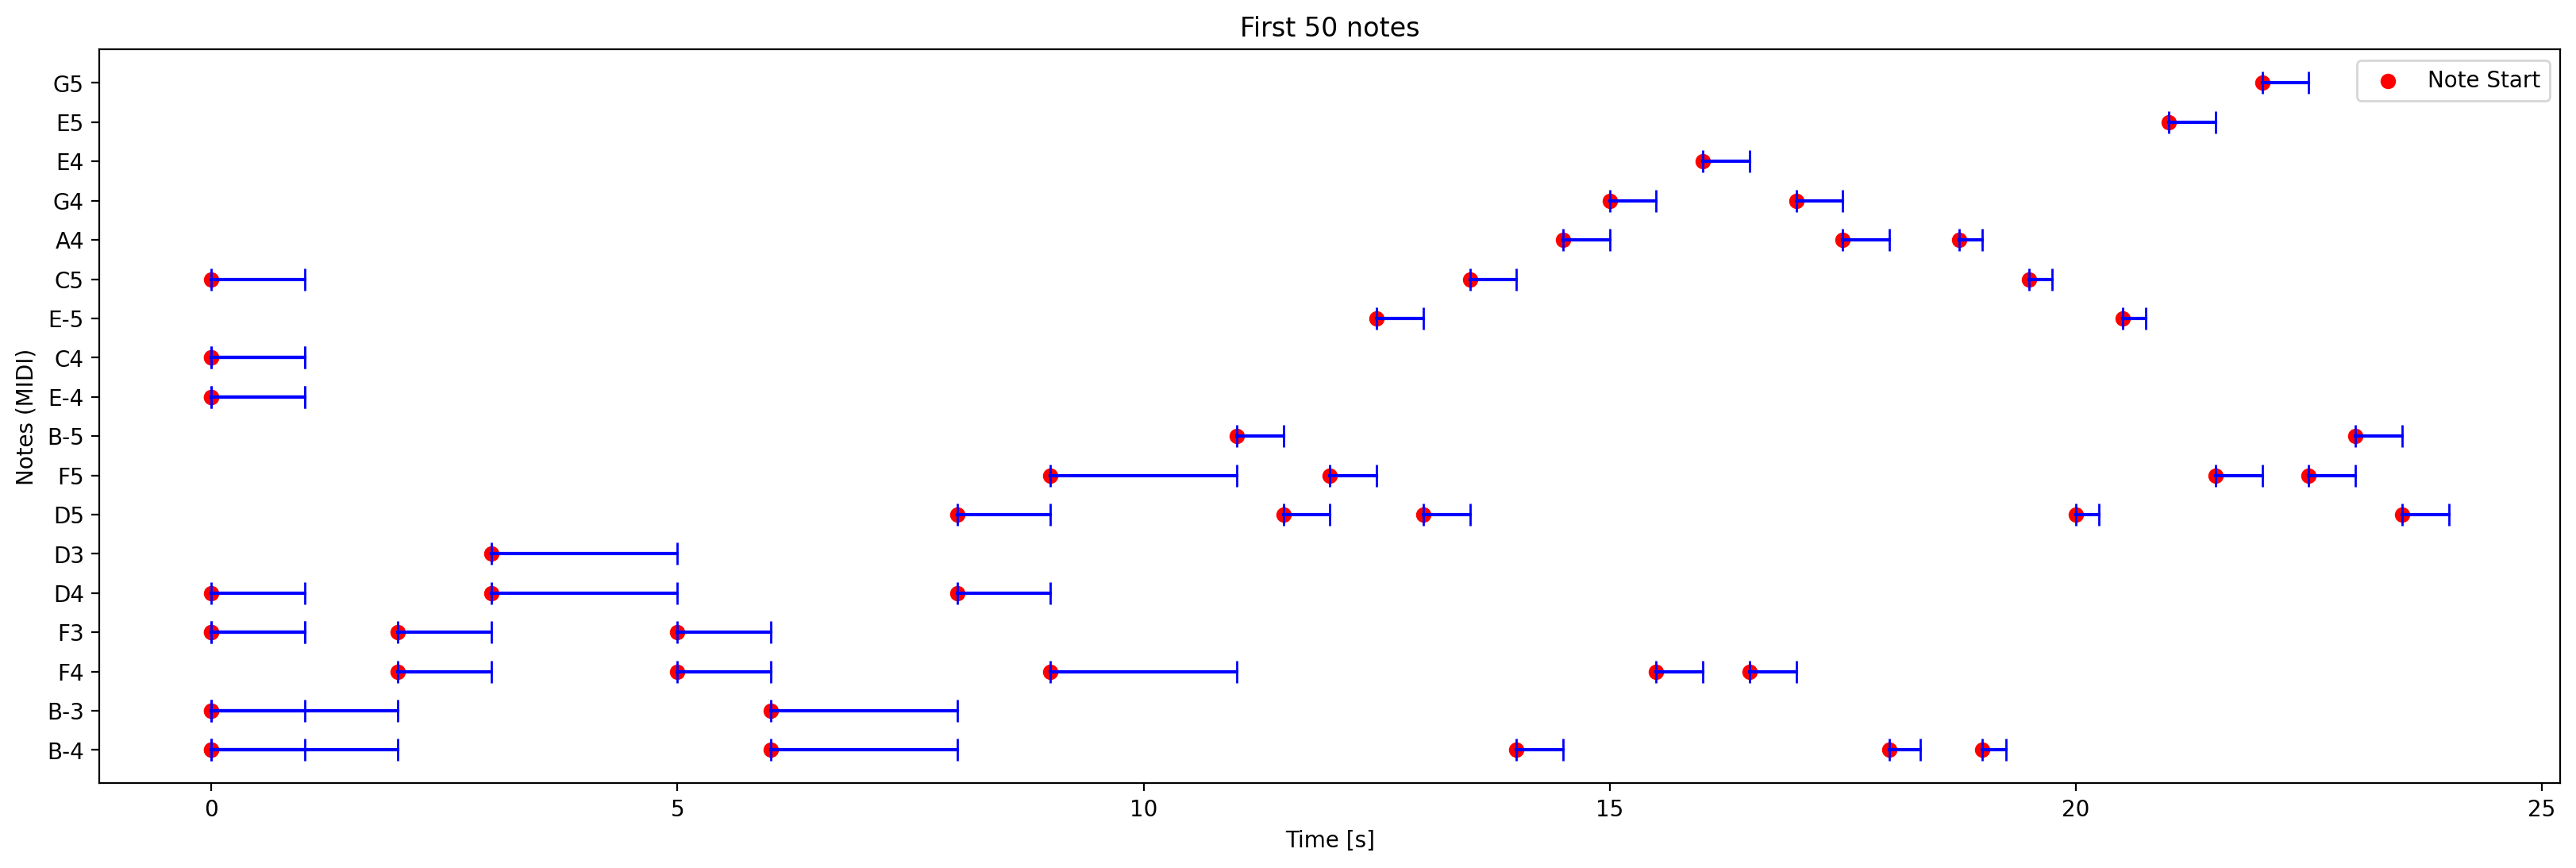

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from music21 import pitch
from typing import Optional

def plot_piano_roll(pitches: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = 'Whole track'
        count = len(pitches['pitch'])

    plt.figure(figsize=(20, 6))
    # Convert pitches from note names to MIDI numbers if necessary

    pitches['midi'] = pitches['notes']

    # Use a scatter plot to show the start of each note
    plt.scatter(pitches['starts'][:count], pitches['midi'][:count], color="r", label="Note Start")
    # Optionally, draw lines or bars to show duration
    for idx in range(min(count, len(pitches))):
        plt.plot([pitches['starts'].iloc[idx], pitches['ends'].iloc[idx]], [pitches['midi'].iloc[idx], pitches['midi'].iloc[idx]], color="b", marker="|", markersize=10)

    plt.xlabel('Time [s]')
    plt.ylabel('Notes (MIDI)')
    plt.title(title)
    plt.legend()
    plt.show()


# Optionally convert pitch to string if they are not already
# pitches_df = pd.DataFrame(pitches)
df_collections['notes'] = df_collections['notes'].astype(str)
print("Len of df_collections: ", len(df_collections))
print("20 samples of df_collections: ")
print(df_collections[:20])
# Plot the piano roll
plot_piano_roll(df_collections, count=50)  # Plot the first 50 notes
